In [0]:
dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/cf_sarimas.csv

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Cost Forecasting with SARIMA") \
    .getOrCreate()

In [0]:
file_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/cf_sarimas.csv"  # Adjust this path
data_df = spark.read.csv(file_path, header=True, inferSchema=True)
data_df.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|  NaN|          0|                  110|                       70|
|PMP*14680*2541| 385.0|873.72|   184|          17|  2021

In [0]:
import pandas as pd
pandas_df = data_df.toPandas()
pandas_df['LastSaleDate'] = pd.to_datetime(pandas_df['LastSaleDate'])
pandas_df.set_index('LastSaleDate', inplace=True)
pandas_df = pandas_df.sort_index()
cost_data = pandas_df['Cost']

In [0]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

def evaluate_sarima(order, seasonal_order, data):
    """
    Evaluate SARIMA model with given orders.
    """
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    forecast = model_fit.forecast(steps=1)
    
    error = mean_squared_error(data[-12:], model_fit.fittedvalues[-12:])
    
    return error, model_fit

In [0]:
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = [12]  # Monthly data, seasonality of 12
import itertools
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            error, model_fit = evaluate_sarima(order, seasonal_order, cost_data)
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = model_fit
        except Exception as e:
            continue

print(f'Best SARIMA Order: {best_order}')
print(f'Best Seasonal Order: {best_seasonal_order}')

Best SARIMA Order: (1, 2, 2)
Best Seasonal Order: (1, 1, 0, 12)


In [0]:
best_model_final = SARIMAX(cost_data, order=best_order, seasonal_order=best_seasonal_order)
best_model_fit = best_model_final.fit(disp=False)

print(best_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                Cost   No. Observations:                   28
Model:             SARIMAX(1, 2, 2)x(1, 1, [], 12)   Log Likelihood                 -35.606
Date:                             Mon, 07 Oct 2024   AIC                             81.212
Time:                                     18:12:52   BIC                             84.407
Sample:                                          0   HQIC                            80.916
                                              - 28                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9959      0.049     20.189      0.000       0.899       1.093
ma.L1         -1.8863     1

           Forecast
2023-05-31      NaN
2023-06-30      NaN
2023-07-31      NaN
2023-08-31      NaN
2023-09-30      NaN
2023-10-31      NaN
2023-11-30      NaN
2023-12-31      NaN
2024-01-31      NaN
2024-02-29      NaN
2024-03-31      NaN
2024-04-30      NaN


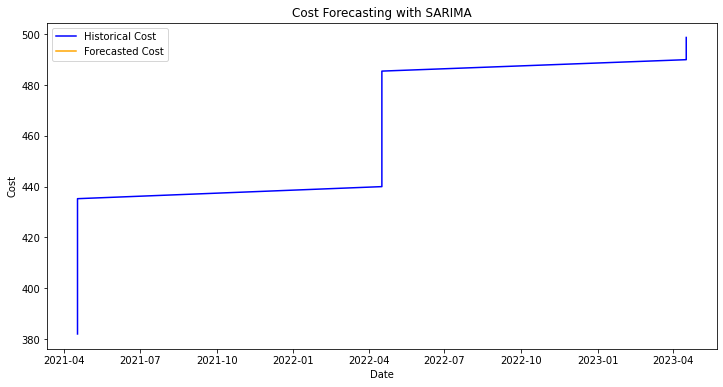

In [0]:
forecast_steps = 12
forecast = best_model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=cost_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_values = forecast.predicted_mean
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['Forecast'])
print(forecast_df)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cost_data, label='Historical Cost', color='blue')
plt.plot(forecast_df, label='Forecasted Cost', color='orange')
plt.title('Cost Forecasting with SARIMA')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [0]:
!pip install mlflow

  Using cached mlflow-2.16.2-py3-none-any.whl (26.7 MB)
  Using cached SQLAlchemy-2.0.35-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached graphene-3.3-py2.py3-none-any.whl (128 kB)
  Using cached docker-7.1.0-py3-none-any.whl (147 kB)
  Using cached flask-3.0.3-py3-none-any.whl (101 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl (85 kB)
  Using cached Markdown-3.7-py3-none-any.whl (106 kB)
  Using cached alembic-1.13.3-py3-none-any.whl (233 kB)
  Using cached mlflow_skinny-2.16.2-py3-none-any.whl (5.6 MB)
  Using cached sqlparse-0.5.1-py3-none-any.whl (44 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl (63 kB)
  Using cached opentelemetry_sdk-1.27.0-py3-none-any.whl (110 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (737 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl 

In [0]:
import mlflow
with mlflow.start_run():
    mlflow.log_param("final_order", best_order)
    mlflow.log_param("final_seasonal_order", best_seasonal_order)
    
    mlflow.sklearn.log_model(best_model_fit, "Final_SARIMA_Model")

mlflow.end_run()

2024/10/07 18:14:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-79de4-6f723-fc5e5-e/tmpmdcf_8m7/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/07 18:14:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/07 18:14:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-rook-591 at: https://community.cloud.databricks.com/ml/experiments/4498943658610024/runs/9fc973ec0c0b48ceb840ad951f09d3f9.
2024/10/07 18:14:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/4498943658610024.
